Linear RMSE - Cases: 1588089.590242486, Deaths: 13018.472754879856
Polynomial RMSE - Cases: 302760.64624032675, Deaths: 4666.032678044967


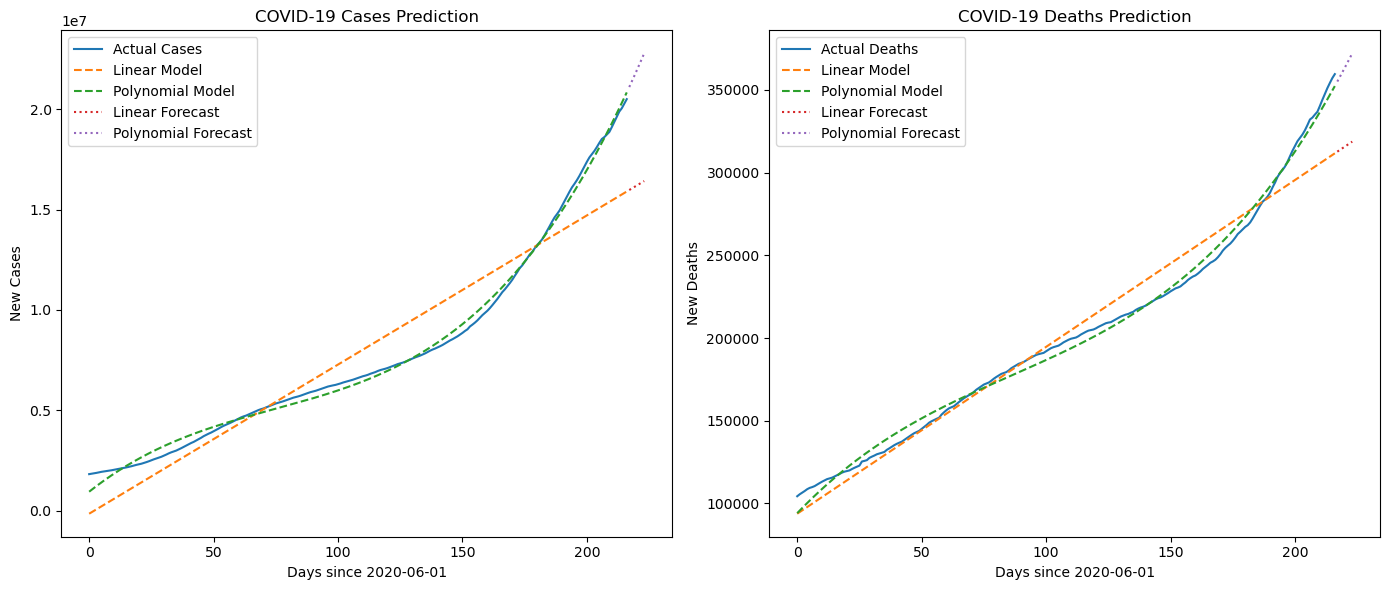

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('US-Covid.csv')

# Extract case and death columns based on column names
case_columns = [col for col in data.columns if '_cases' in col]
death_columns = [col for col in data.columns if '_deaths' in col]  # Adjust if death columns follow this format

# Transform date columns to rows
cases = data.melt(id_vars=['State', 'StateFIPS', 'population'], value_vars=case_columns,
                  var_name='date', value_name='cases')
cases['date'] = cases['date'].str.replace('_cases', '')

deaths = data.melt(id_vars=['State', 'StateFIPS', 'population'], value_vars=death_columns,
                   var_name='date', value_name='deaths')
deaths['date'] = deaths['date'].str.replace('_deaths', '')

# Merge cases and deaths
data_long = pd.merge(cases, deaths, on=['State', 'StateFIPS', 'population', 'date'])
data_long['date'] = pd.to_datetime(data_long['date'])

# Aggregate data by date to analyze across the U.S.
data_agg = data_long.groupby('date').sum().reset_index()

# Filter for the date range
start_date = '2020-06-01'
end_date = '2021-01-03'
data_agg = data_agg[(data_agg['date'] >= start_date) & (data_agg['date'] <= end_date)]

# Create X (days since start) and Y (cases, deaths)
data_agg['days_since_start'] = (data_agg['date'] - pd.to_datetime(start_date)).dt.days
X = data_agg[['days_since_start']]
y_cases = data_agg['cases']
y_deaths = data_agg['deaths']

# Step 1: Linear Regression Model
# Linear regression for cases
linear_model_cases = LinearRegression()
linear_model_cases.fit(X, y_cases)
y_cases_pred_linear = linear_model_cases.predict(X)

# Linear regression for deaths
linear_model_deaths = LinearRegression()
linear_model_deaths.fit(X, y_deaths)
y_deaths_pred_linear = linear_model_deaths.predict(X)

# Step 2: Polynomial Regression Model
# Choose a polynomial degree (e.g., degree = 3)
degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Polynomial regression for cases
poly_model_cases = LinearRegression()
poly_model_cases.fit(X_poly, y_cases)
y_cases_pred_poly = poly_model_cases.predict(X_poly)

# Polynomial regression for deaths
poly_model_deaths = LinearRegression()
poly_model_deaths.fit(X_poly, y_deaths)
y_deaths_pred_poly = poly_model_deaths.predict(X_poly)

# Step 3: Calculate RMSE for each model
rmse_cases_linear = np.sqrt(np.mean((y_cases - y_cases_pred_linear) ** 2))
rmse_deaths_linear = np.sqrt(np.mean((y_deaths - y_deaths_pred_linear) ** 2))
rmse_cases_poly = np.sqrt(np.mean((y_cases - y_cases_pred_poly) ** 2))
rmse_deaths_poly = np.sqrt(np.mean((y_deaths - y_deaths_pred_poly) ** 2))

print(f"Linear RMSE - Cases: {rmse_cases_linear}, Deaths: {rmse_deaths_linear}")
print(f"Polynomial RMSE - Cases: {rmse_cases_poly}, Deaths: {rmse_deaths_poly}")

# Step 4: Forecasting 1 Week Ahead
# Extend the X-axis for prediction
future_days = 7
X_future = pd.DataFrame({'days_since_start': np.arange(X['days_since_start'].max() + 1, X['days_since_start'].max() + 1 + future_days)})
X_poly_future = poly_features.transform(X_future)

# Predict future cases and deaths
y_cases_future_linear = linear_model_cases.predict(X_future)
y_deaths_future_linear = linear_model_deaths.predict(X_future)
y_cases_future_poly = poly_model_cases.predict(X_poly_future)
y_deaths_future_poly = poly_model_deaths.predict(X_poly_future)

# Step 5: Plot the Data and Predictions
plt.figure(figsize=(14, 6))

# Cases Plot
plt.subplot(1, 2, 1)
plt.plot(data_agg['days_since_start'], y_cases, label="Actual Cases")
plt.plot(data_agg['days_since_start'], y_cases_pred_linear, label="Linear Model", linestyle="--")
plt.plot(data_agg['days_since_start'], y_cases_pred_poly, label="Polynomial Model", linestyle="--")
plt.plot(X_future['days_since_start'], y_cases_future_linear, label="Linear Forecast", linestyle=":")
plt.plot(X_future['days_since_start'], y_cases_future_poly, label="Polynomial Forecast", linestyle=":")
plt.title("COVID-19 Cases Prediction")
plt.xlabel("Days since 2020-06-01")
plt.ylabel("New Cases")
plt.legend()

# Deaths Plot
plt.subplot(1, 2, 2)
plt.plot(data_agg['days_since_start'], y_deaths, label="Actual Deaths")
plt.plot(data_agg['days_since_start'], y_deaths_pred_linear, label="Linear Model", linestyle="--")
plt.plot(data_agg['days_since_start'], y_deaths_pred_poly, label="Polynomial Model", linestyle="--")
plt.plot(X_future['days_since_start'], y_deaths_future_linear, label="Linear Forecast", linestyle=":")
plt.plot(X_future['days_since_start'], y_deaths_future_poly, label="Polynomial Forecast", linestyle=":")
plt.title("COVID-19 Deaths Prediction")
plt.xlabel("Days since 2020-06-01")
plt.ylabel("New Deaths")
plt.legend()

plt.tight_layout()
plt.show()
